In [0]:
%pip install arrow
%pip install numba
%pip install Jinja2

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Looking in indexes: https://artifactory.aus.optiver.com/artifactory/api/pypi/python-all/simple, https://artifactory.aus.optiver.com/artifactory/api/pypi/python-centos7/simple
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Looking in indexes: https://artifactory.aus.optiver.com/artifactory/api/pypi/python-all/simple, https://artifactory.aus.optiver.com/artifactory/api/pypi/python-centos7/simple
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
from common_databricks.dataframe_utils import merge_asof_pyspark
from datetime import date, time
from zoneinfo import ZoneInfo 
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F
from pyspark.sql import Window
import datetime as dt
import pandas as pd
import numpy as np
import json

In [0]:
def get_and_persist_omdc(feedcodes, date_to_run, path="/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/data/ConflatedBrokerQueue_{date_to_run}.parquet"):
    selected_columns = ['t0', 'omd_send_ts', 'eeid_event_id', 'security_code', 'side', 'item', 'type', 'broker_queue_msg_index']

    OMDC = (spark.read.parquet(f"/Volumes/external/opapac-ess-prd-apse2/hacksaw/sehk/omdc_broker_queue/market_session_date={date_to_run.isoformat()}/")
            .filter(F.col("security_code").isin(feedcodes))
            .select(*selected_columns)
            .toPandas())

    OMDC = OMDC.rename(columns = {
        "t0": "received_",
        "omd_send_ts": "timestampNanos_",
        "security_code":"securityCode_",
        "side": "side_",
    })

    OMDC["priority_pre_step"] = np.where(OMDC["type"] == "B", 1, 0)
    OMDC = OMDC.sort_values(by=['eeid_event_id','securityCode_','side_','broker_queue_msg_index']).reset_index(drop=True)
    OMDC["priority_"] = OMDC.groupby(['eeid_event_id','securityCode_','side_'])["priority_pre_step"].cumsum()-1
    OMDC["level_pre_step"] = np.where(OMDC["item"] == 0, 0,np.where(OMDC["type"] == "S", 1, 0))
    OMDC["level_"] = OMDC.groupby(['eeid_event_id','securityCode_','side_'])["level_pre_step"].cumsum()

    OMDC = OMDC.drop(columns=['priority_pre_step', 'level_pre_step'])
    OMDC = OMDC.rename(columns = {"item":"brokerNumber_"})

    OMDC["createdNanos_"] = OMDC["received_"]
    OMDC = OMDC[OMDC["type"]=="B"].sort_values(['eeid_event_id','securityCode_','side_','broker_queue_msg_index']).reset_index(drop = True)

    path_final = path.format(date_to_run=date_to_run)
    OMDC.to_parquet(path_final)
    return path_final

In [0]:
def get_sql_file(feedcodes, date_to_run,path, database='delete_operation'):
    time_filed = "publish_time" if database not in ["private_trade","public_trade"] else "trade_time"
    
    start_time = dt.datetime.combine(date_to_run, dt.time(0))
    end_time = start_time + dt.timedelta(days=1)
    start_time = int(start_time.timestamp() * 1e9)
    end_time = int(end_time.timestamp() * 1e9)

    feedcodes = [str(x) if isinstance(x, int) else x for x in feedcodes]
    feedcode_list = "', '".join(feedcodes)

    q = f"""
    SELECT *
    FROM
        foundation_prod.core_trades.{database}
    WHERE
        {time_filed} BETWEEN {start_time} AND {end_time}
        AND mic = 'XHKG'
        AND feedcode IN ('{feedcode_list}')
    """
    df = spark.sql(q).toPandas()
    df.to_parquet(path)

# For delete_operation (DELETES), order_insert (ADDs), private_trade

In [0]:
def get_private_feed_confirms(feedcodes, date_to_run, path, database='xhkg_sst_trade'):
    start_time = dt.datetime.combine(date_to_run, dt.time(0))
    end_time = start_time + dt.timedelta(days=1)
    start_time = int(start_time.timestamp() * 1e9)
    end_time = int(end_time.timestamp() * 1e9)

    feedcodes = [str(x) if isinstance(x, int) else x for x in feedcodes]
    feedcode_list = "', '".join(feedcodes)

    q = f"""
    SELECT *
    FROM
        foundation_prod.decoded_exec.{database}
    WHERE
        log_time BETWEEN {start_time} AND {end_time}
        AND feedcode IN ('{feedcode_list}')
    """
    df = spark.sql(q).toPandas()
    df.to_parquet(path)

# For trade_confirms

In [0]:
import numpy as np
from collections import defaultdict, deque

# order_id, price, volume, side
order_type = np.dtype([
    ('order_id', np.int64),
    ('price', np.float64),
    ('volume', np.float64),
    ('side', np.int8)
])

# passive_order_id, aggressive_order_id, volume_before, volume_after
trade_type = np.dtype([
    ('passive_order_id', np.int64),
    ('aggressive_order_id', np.int64),
    ('volume_before', np.float64),
    ('volume_after', np.float64)
])

# operation, order_id, price, volume, side, changeReason
ignored_request_type = np.dtype([
    ('operation', np.int8),
    ('order_id', np.int64),
    ('price', np.float64),
    ('volume', np.int64),
    ('side', np.int8),
    ('changeReason', np.int8)
])


def process_order_book(messages, delete_order_ids):
    bids = defaultdict(deque)
    asks = defaultdict(deque)

    trades = []
    ignored_requests = []
    """
    For the aggressive add orders we want to make a LIST of modify + delete we expect for PASSIVE orders
    We also want to store this information for the passive orders
    """

    aggressive_orders_expected = {}
    passive_orders_expected = {}


    for msg in messages:
        operation_code = msg['operation_code']
        order_id = int(msg['order_id'])
        price = msg['price']
        volume = int(msg['volume'])
        side = msg['side']

        if operation_code == 0:  # ADD
            add_order(bids, asks, order_id, price, volume, side, trades, aggressive_orders_expected, passive_orders_expected, delete_order_ids)
        elif operation_code == 1:  # MODIFY
            modify_order(bids, asks, order_id, volume, ignored_requests, msg, aggressive_orders_expected, passive_orders_expected)
        elif operation_code == 2:  # DELETE
            delete_order(bids, asks, order_id, ignored_requests, msg, aggressive_orders_expected, passive_orders_expected)

    return trades, ignored_requests, aggressive_orders_expected, passive_orders_expected


def add_order(bids, asks, order_id, price, volume, side, trades, aggressive_orders_expected, passive_orders_expected, delete_order_ids):
    if side == 0:  # Buy order
        if asks:
            best_ask_price = min(asks.keys())
            if price >= best_ask_price:
                remaining_volume = match_order(
                    order_id, price, volume, side, asks, trades, aggressive_orders_expected, passive_orders_expected
                )
                if remaining_volume > 0:
                    if order_id in delete_order_ids:
                        """
                        This is a FAK - they have done ADD then DELETE
                        """
                        pass
                    else:
                        insert_order(bids, order_id, price, remaining_volume, side)
            else:
                insert_order(bids, order_id, price, volume, side)
        else:
            insert_order(bids, order_id, price, volume, side)
    else:  # Sell order
        if bids:
            best_bid_price = max(bids.keys())
            if price <= best_bid_price:
                remaining_volume = match_order(
                    order_id, price, volume, side, bids, trades, aggressive_orders_expected, passive_orders_expected
                )
                if remaining_volume > 0:
                    if order_id in delete_order_ids:
                        """
                        This is a FAK - they have done ADD then DELETE
                        """
                        pass
                    else:
                        insert_order(asks, order_id, price, remaining_volume, side)
            else:
                insert_order(asks, order_id, price, volume, side)
        else:
            insert_order(asks, order_id, price, volume, side)


def insert_order(book, order_id, price, volume, side):
    order = {'order_id': order_id, 'price': price, 'volume': volume, 'side': side}
    book[price].append(order)


def match_order(active_order_id, active_price, active_volume, active_side, opposite_book, trades, aggressive_orders_expected, passive_orders_expected):
    remaining_volume = active_volume
    prices = list(opposite_book.keys())
    
    if active_side == 0:  
        prices.sort()
    else:  
        prices.sort(reverse=True)
    
    for price in prices:
        if (active_side == 0 and active_price < price) or (active_side == 1 and active_price > price):
            break

        while opposite_book[price] and remaining_volume > 0:
            resting_order = opposite_book[price][0] 
            trade_volume = min(remaining_volume, resting_order['volume'])
            """
            Passive order - do we expect a MODIFY or DELETE
            """
            if trade_volume < resting_order['volume']:
                passive_orders_expected.setdefault(resting_order['order_id'], []).append(
                    (resting_order['order_id'], resting_order['volume'] - trade_volume, "Modify", active_order_id)
                )
            else:
                passive_orders_expected.setdefault(resting_order['order_id'], []).append(
                    (resting_order['order_id'], 0, "Delete", active_order_id)
                )
            
            """
            Aggressive order - do we expect a MODIFY or DELETE
            """
            if trade_volume < remaining_volume:
                aggressive_orders_expected.setdefault(active_order_id, []).append(
                    (active_order_id, remaining_volume - trade_volume, "Modify", resting_order['order_id'])
                )
            else:
                aggressive_orders_expected.setdefault(active_order_id, []).append(
                    (active_order_id, 0, "Delete", resting_order['order_id'])
                )
        
            trade = {
                'passive_order_id': resting_order['order_id'],
                'aggressive_order_id': active_order_id,
                'volume_before': resting_order['volume'],
                'volume_after': resting_order['volume'] - trade_volume
            }
            trades.append(trade)

            remaining_volume -= trade_volume
            updated_volume = resting_order['volume'] - trade_volume

            if updated_volume == 0:
                opposite_book[price].popleft()
            else:
                opposite_book[price][0]['volume'] = updated_volume

        if not opposite_book[price]:
            del opposite_book[price]

        if remaining_volume == 0:
            break

    return remaining_volume

def modify_order(bids, asks, order_id, new_volume, ignored_requests, msg, aggressive_orders_expected, passive_orders_expected):
    """
    If the modify is for an AGGRESSIVE ORDER
        a) Check that the orderIf exists in aggressive_order 
            -- If it DOESNT ... do the passive order check
            -- If it DOES ... this is the modify following an aggressor ADD

    If the modify is for a PASSIVE ORDER:
        a)  Check that the orderId exists in passive_expected
            -- If it DOESNT ... this is genuinge modify
            -- If it DOES ... we check if we can find the exact object:
                b) if we can ... this is related to trade
                        -- check if this is the LAST message -- if it is ... then it should have end_ = True
                        -- if not the last message ... end_ = False
                -- if we cannot ... this is genuinge modify 
    """
    if order_id in aggressive_orders_expected:
        record_ignored_request(ignored_requests, msg, change_reason=4, last_message=False, agg_id = None) # Genuine modify for aggressor

    elif order_id in passive_orders_expected:
        full_match_list = passive_orders_expected[order_id]
        potential_matches = [x for x in full_match_list if (x[1] == new_volume and x[2] == "Modify")]
        if len(potential_matches) > 0:
            last_message = passive_orders_expected[order_id].index(potential_matches[0]) == len(passive_orders_expected[order_id])-1
            aggressor = potential_matches[0][-1]
            record_ignored_request(ignored_requests, msg, change_reason=3, last_message=last_message, agg_id=aggressor)
        else:
            record_ignored_request(ignored_requests, msg, change_reason=2, last_message=True, agg_id=None) # Genuine modify 
            search_and_modify_order(bids, order_id, new_volume, ignored_requests, msg)
            search_and_modify_order(asks, order_id, new_volume, ignored_requests, msg)
    else:
        record_ignored_request(ignored_requests, msg, change_reason=2, last_message=True, agg_id=None) # Genuine modify 
        search_and_modify_order(bids, order_id, new_volume, ignored_requests, msg)
        search_and_modify_order(asks, order_id, new_volume, ignored_requests, msg)


def search_and_modify_order(book, order_id, new_volume, ignored_requests, msg):
    for price in book:
        level_orders = book[price]
        for order in level_orders:
            if order['order_id'] == order_id:
                if new_volume >= order['volume']:
                    return True
                else:
                    order['volume'] = new_volume
                    return True
    return False

def delete_order(bids, asks, order_id, ignored_requests, msg, aggressive_orders_expected, passive_orders_expected):
    """
    If the delete is for an AGGRESSIVE ORDER
        a) Check that the orderIf exists in aggressive_order 
            -- If it DOESNT ... do the passive order check
            -- If it DOES ... this is a delete following an ADD

    If the modify is for a PASSIVE ORDER:
        a)  Check that the orderId exists in passive_expected
            -- If it DOESNT ... this is genuinge modify
            -- If it DOES ... we check if we can find the exact object:
                b) if we can ... this is related to trade
                        -- check if this is the LAST message -- if it is ... then it should have end_ = True
                        -- if not the last message ... end_ = False
                -- if we cannot ... this is genuinge modify 
    """
    if order_id in aggressive_orders_expected:
        record_ignored_request(ignored_requests, msg, change_reason=4, last_message=False, agg_id = None)   # Genuine delete for competitor. 
    elif order_id in passive_orders_expected:
        potential_matches = [x for x in passive_orders_expected[order_id] if (x[1] == 0 and x[2] == "Delete")]
        if len(potential_matches) > 0:
            last_message = passive_orders_expected[order_id].index(potential_matches[0]) == len(passive_orders_expected[order_id])-1
            aggressor = potential_matches[0][-1]
            record_ignored_request(ignored_requests, msg, change_reason=3, last_message=last_message, agg_id=aggressor)
        else:
            record_ignored_request(ignored_requests, msg, change_reason=1, last_message=True, agg_id=None) # Genuine Delete 
            search_and_delete_order(asks, order_id)
            search_and_delete_order(bids, order_id)
    else:
        record_ignored_request(ignored_requests, msg, change_reason=1, last_message=True, agg_id=None) # Genuine Delete 
        search_and_delete_order(asks, order_id)
        search_and_delete_order(bids, order_id)


def search_and_delete_order(book, order_id):
    for price in list(book.keys()):
        level_orders = book[price]
        for i in range(len(level_orders)):
            if level_orders[i]['order_id'] == order_id:
                del level_orders[i]
                if not level_orders:
                    del book[price]
                return True
    return False

def record_ignored_request(ignored_requests, msg, change_reason, last_message, agg_id):
    ignored_request = {
        'sequence' : msg['sequence'],
        'operation': msg['operation_code'],
        'order_id': msg['order_id'],
        'price': msg['price'],
        'volume': msg['volume'],
        'side': msg['side'],
        'changeReason': change_reason,
        'aggressorId':agg_id,
        'end':last_message
    }
    ignored_requests.append(ignored_request)


In [0]:
def prepare_messages(df):
    operation_mapping = {'Add': 0, 'Modify': 1, 'Delete': 2}
    side_mapping = {'B': 0, 'A': 1}
    df['operation_code'] = df['operation'].map(operation_mapping)
    df['side'] = df['side'].map(side_mapping)
    required_columns = ['sequence', 'operation_code', 'order_id', 'price', 'volume', 'side']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' is missing from the DataFrame.")

    message_dtype = np.dtype([
        ('sequence', np.int64),
        ('operation_code', np.int8),
        ('order_id', np.int64),
        ('price', np.float64),
        ('volume', np.float64),
        ('side', np.int8),
    ])

    data = df[required_columns].to_records(index=False)
    messages_array = np.array(data, dtype=message_dtype)

    return messages_array


In [0]:
from concurrent.futures import ProcessPoolExecutor, as_completed
import pandas as pd
import numpy as np
import os

def process_change_reason(orderBook, trades, ignored_requests):
    change_reason_map = {item['sequence']: item['changeReason'] for item in ignored_requests}
    sequence_to_aggressorId = {item["sequence"]:item["aggressorId"] for item in ignored_requests}
    sequence_to_end = {item["sequence"]:item["end"] for item in ignored_requests}
    orderBook["end_"] = orderBook["sequence"].map(sequence_to_end).fillna(True)
    orderBook["aggressorId_"] = orderBook["sequence"].map(sequence_to_aggressorId)
    orderBook["changeReason_traded"] = orderBook["sequence"].map(change_reason_map).fillna(0).astype(int)
    try:
        orderBook["changeReason_"] = np.where(
            orderBook["changeReason_traded"] == 0, 
            orderBook["changeReason_"], 
            orderBook["changeReason_traded"]
        )
    except ValueError as e:
        print(f"Broadcasting error in np.where for 'changeReason_': {e}")
        print(f"Shapes: changeReason_traded: {orderBook['changeReason_traded'].shape}, changeReason_: {orderBook['changeReason_'].shape}")
        raise

    mask = orderBook["changeReason_"] == 4
    subset = orderBook[mask].copy()
    grouped = subset.groupby('order_id')
    orders_with_delete = grouped.apply(lambda g: 'Delete' in g['operation'].values)
    orders_with_delete = orders_with_delete[orders_with_delete].index.tolist()
    orders_without_delete = grouped.apply(lambda g: 'Delete' not in g['operation'].values).index.tolist()

    if orders_with_delete:
        """
        Delete operations related to aggressive order. 
        """
        delete_mask = (orderBook['changeReason_'] == 4) & \
                      (orderBook['operation'] == 'Delete') & \
                      (orderBook['order_id'].isin(orders_with_delete))
        orderBook.loc[delete_mask, 'end_'] = True
        remove_mask_with_delete = (mask) & \
                                   (orderBook['order_id'].isin(orders_with_delete)) & \
                                   (~delete_mask)
        orderBook = orderBook[~remove_mask_with_delete]
    
    if orders_without_delete:
        isin_orders_without_delete = orderBook['order_id'].isin(orders_without_delete)
        subset = orderBook.loc[mask & isin_orders_without_delete]
        """
        Orders without delete operations. Here we find the LAST MODIFY associated w/ the delete and remove all other useless shit. 
        """
        subset_sorted = subset.sort_values(['order_id', 'sequence', 't0', 'omd_send_ts'], ascending=[True, True, True, True])
        last_modifies = subset_sorted.groupby('order_id').tail(1)
        
        last_modify_indices = last_modifies.index.tolist()
        orderBook.loc[last_modify_indices, 'end_'] = True

        remove_mask_without_delete = (orderBook["changeReason_"]==4) & (orderBook['order_id'].isin(orders_without_delete)) & (~orderBook.index.isin(last_modify_indices))
        orderBook = orderBook[~remove_mask_without_delete]
    
    try:
        condition = orderBook["changeReason_"] == 4
        orderBook.loc[condition & (orderBook["operation"] == "Delete"), "changeReason_"] = 1
        orderBook.loc[condition & (orderBook["operation"] != "Delete"), "changeReason_"] = 2
    except ValueError as e:
        print(f"Broadcasting error while updating 'changeReason_': {e}")
        print(f"Shapes: changeReason_: {orderBook['changeReason_'].shape}, operation: {orderBook['operation'].shape}")
        raise

    orderBook=orderBook.sort_values("sequence").reset_index(drop = True)
    
    return orderBook

def _process_feedcode(feedcode, OB_subset):
    """
    Helper function to process a single feedcode subset.
    """
    OB_subset["changeReason_"] = np.where(
        OB_subset["operation"] == "Add", 0,
        np.where(
            OB_subset["operation"] == "Modify", 2, 
            np.where(OB_subset["operation"] == "Delete", 1, np.nan)
        )
    )
    
    OB_subset = OB_subset.sort_values(["sequence", "eeid_event_id"]).reset_index(drop=True)

    delete_order_ids = OB_subset[OB_subset["operation"] == "Delete"]["order_id"].values
    orderBook_messages = prepare_messages(OB_subset)
    trades, ignored_requests, aggressive_orders_expected, passive_orders_expected = process_order_book(orderBook_messages, delete_order_ids)
    OB_subset = process_change_reason(OB_subset, trades, ignored_requests)
    
    return OB_subset, ignored_requests, trades, aggressive_orders_expected, passive_orders_expected

def get_process_and_persist_orderbook(feedcodes, date_to_run, path="/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/data/OMDCRaw_{date_to_run}.parquet"):
    selected_columns = [
        "feedcode", "order_id", "t0", "eeid_event_id", "operation", 
        "orderbook_id", "omd_send_ts", "volume", "price", "sequence", "side"
    ]

    OB = (
        spark.read.parquet(
            f"/Volumes/external/opapac-ess-prd-apse2/hacksaw/sehk/omdc_orderbook/market_session_date={date_to_run}/"
        )
        .filter(F.col("feedcode").isin(feedcodes))
        .select(*selected_columns)
        .toPandas()
    )
    orderbook_list = []

    unique_feedcodes = OB["feedcode"].unique()

    max_workers = min(32, os.cpu_count() + 4)  # Example heuristic

    ignored = {}
    trades_dict = {}
    aggressive = {}
    passive = {}
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        future_to_feedcode = {
            executor.submit(_process_feedcode, feedcode, OB[OB["feedcode"] == feedcode].copy()): feedcode
            for feedcode in unique_feedcodes
        }
        for future in as_completed(future_to_feedcode):
            feedcode = future_to_feedcode[future]
            try:
                processed_subset, ignored_requests, trades, aggressive_orders_expected, passive_orders_expected = future.result()
                trades_dict[feedcode] = trades
                aggressive[feedcode] = aggressive_orders_expected
                passive[feedcode] = passive_orders_expected
                ignored[feedcode] = ignored_requests
                orderbook_list.append(processed_subset)
            except Exception as exc:
                print(f'Feedcode {feedcode} generated an exception: {exc}')

    orderBook = pd.concat(orderbook_list, ignore_index=True)
    operations_map = {
        "Add": 0,
        "Modify": 1,
        "Delete": 2,
        "Clear": 3,
    }
    orderBook = orderBook.rename(columns={
        "feedcode": "securityCode_",
        "order_id": "orderId_",
        "t0": "received_",
        "omd_send_ts": "timestampNanos_",
        "sequence": "sequenceNumber_",
        "volume": "volume_",
        "price": "price_",
    })
    orderBook["aggressorOrderId_"] = np.nan
    orderBook["createdNanos_"] = orderBook["received_"]
    orderBook["side"] = orderBook["side"].map({0:"B", 1:"S"})
    orderBook["side_"] = orderBook["side"].apply(lambda x: ord(x))
    orderBook["class_"] = orderBook["operation"].map(operations_map)

    final_path = path.format(date_to_run=date_to_run)
    os.makedirs(os.path.dirname(final_path), exist_ok=True)
    orderBook.to_parquet(final_path, index=False)

    return final_path, orderBook, ignored, trades, aggressive_orders_expected, passive_orders_expected

##### **Get raw data & store**
1) order_insert
2) delete_operation_path
3) private_trade_path
4) private_feed_confirm (w/ counterparty)
5) OMDC conflated-broker-queue
6) OMDC_orderbook (add, modify, deletes)

In [0]:
with open("/Workspace/Users/kartikeya.bisht@optiver.com.au/universe.json", "r") as file:
    universe = json.load(file)

feedcodes =sorted([x[5:] for x in universe['all']])

date_to_run = dt.datetime.now().date() - dt.timedelta(days = 1)
date_to_run = dt.datetime(2024,9,20).date()

In [0]:
print(f"RUNNING FOBA CREATE for {date_to_run.isoformat()} for {len(feedcodes)} symbols in HK-CASH universe")

RUNNING FOBA CREATE for 2024-09-20 for 148 symbols in HK-CASH universe


In [0]:
raw_data_paths = {}

In [0]:
data_base_mapping = {
    "order_insert_path":"order_insert",
    "delete_operation_path":"delete_operation",
    "private_trade_path":"private_trade",
    "private_feed_path":"xhkg_sst_trade"
}

In [0]:
generic_path = "/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/data/{key}_{date_to_run}.parquet"

for key, value in data_base_mapping.items():
    raw_data_paths[key] = generic_path.format(key=key, date_to_run=date_to_run)
    if key != "private_feed_path":
        get_sql_file(feedcodes, date_to_run, path=raw_data_paths[key], database=value)
    else:
        get_private_feed_confirms(feedcodes, date_to_run, path=raw_data_paths[key], database=value)
    
    print(f"Finished {key}")

Finished order_insert_path
Finished delete_operation_path
Finished private_trade_path
Finished private_feed_path


In [0]:
final_CBQ_path = get_and_persist_omdc(feedcodes, date_to_run)
raw_data_paths["conflated_broker_queue_path"] = final_CBQ_path

In [0]:
final_OMDC_path, orderBook, ignored_requests, trades, aggressive, passive = get_process_and_persist_orderbook(feedcodes, date_to_run)
raw_data_paths["order_book_path"] = final_OMDC_path

In [0]:
config  = {
    **raw_data_paths,
    "fee_info_path":"/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/FeeInfo.feather",
    "tick_schedule_path" : "/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/TickSchedule.feather",
    "fee_schedule_path" : "/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/FeeSchedule.feather"
}

In [0]:
import foba_backtest_engine.engine as FOBA
from importlib import reload
FOBA = reload(FOBA)

/local_disk0/.ephemeral_nfs/envs/pythonEnv-4d67cdef-1061-4f7d-8df9-461e67264600/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [0]:
def run_foba_analysis(
    date,
    mode="passive_analysis",
    book_ids=[],
    config=None,
    result_type="dataframe", 
):
    if book_ids is None:
        raise ValueError("need to provide symbols")
    if isinstance(book_ids, str):
        book_ids = [book_ids]

    engine = FOBA.Engine(
        mode=mode,
        book_ids=book_ids,
        date=date,
        config=config,
        result_type=result_type
    )
    engine.run()
    
    return engine

In [0]:
config

{'order_insert_path': '/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/data/order_insert_path_2024-09-20.parquet',
 'delete_operation_path': '/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/data/delete_operation_path_2024-09-20.parquet',
 'private_trade_path': '/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/data/private_trade_path_2024-09-20.parquet',
 'private_feed_path': '/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/data/private_feed_path_2024-09-20.parquet',
 'conflated_broker_queue_path': '/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/data/ConflatedBrokerQueue_2024-09-20.parquet',
 'order_book_path': '/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/data/OMDCRaw_2024-09-20.parquet',
 'fee_info_path': '/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/FeeInfo.feather',
 'tick_schedule_path': '/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/TickSchedule.feather',
 'fee_schedule_path': '

In [0]:
# config = {'order_insert_path': '/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/data/order_insert_path_2024-09-20.parquet',
#  'delete_operation_path': '/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/data/delete_operation_path_2024-09-20.parquet',
#  'private_trade_path': '/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/data/private_trade_path_2024-09-20.parquet',
#  'private_feed_path': '/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/data/private_feed_path_2024-09-20.parquet',
#  'conflated_broker_queue_path': '/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/data/ConflatedBrokerQueue_2024-09-20.parquet',
#  'order_book_path': '/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/data/OMDCRaw_2024-09-20.parquet',
#  'fee_info_path': '/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/FeeInfo.feather',
#  'tick_schedule_path': '/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/TickSchedule.feather',
#  'fee_schedule_path': '/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/FeeSchedule.feather'}

In [0]:
omdc_foba = run_foba_analysis(
    date=dt.datetime.combine(date_to_run, time(0,0)),
    mode="passive_analysis",
    book_ids=["5"],
    config=config
)

2024-10-25 06:56:41,734 - foba_backtest_engine.engine - DEBUG - Passive Analysis Mode: Started
2024-10-25 06:56:41,737 - foba_backtest_engine.enrichment - DEBUG - Running processor: order_numbers_filtered
2024-10-25 06:56:42,830 - foba_backtest_engine.enrichment - DEBUG - order_numbers_filtered produced 174 results
2024-10-25 06:56:42,830 - foba_backtest_engine.enrichment - DEBUG - Running processor: pybuilders
2024-10-25 06:56:48,672 - foba_backtest_engine.components.order_book.builders.multi_book_builder - DEBUG - build_books using OmdcBookBuilder: Started
2024-10-25 06:56:48,673 - foba_backtest_engine.components.order_book.builders.multi_book_builder - DEBUG - build_books using OmdcBookBuilder: Timerange - 2024-09-20 06:00:00-2024-09-20 16:01:00
2024-10-25 06:56:48,673 - foba_backtest_engine.components.order_book.builders.multi_book_builder - DEBUG - build_books using OmdcBookBuilder: feed_update_count - 74994
2024-10-25 06:56:54,339 - foba_backtest_engine.components.order_book.buil

                                     TimeTaken
pybuilders                           89.068314
omdc_broker_queue                    55.929159
omdc_order_number_to_broker_number   42.592908
event_enricher                       18.685942
annotate_slippages                    7.932564
competitor_enrichment                 1.657632
get_optiver_trades                    1.231650
order_numbers_filtered                1.093078
order_state_creates                   0.970626
broker_orders_enrichment              0.865629
full_feed_state_enrichment            0.509295
static_data_info                      0.418169
omdc_broker_number_to_name            0.378129
derived_enrichment                    0.335209
feed_states_at_join                   0.316462
order_deletes                         0.127622
extract_foba_events                   0.125262
send_times                            0.093729
static_data_enrichment                0.057899
optiver_trade_and_quotes              0.025806
foreign_count

2024-10-25 07:00:25,010 - foba_backtest_engine.engine - DEBUG - Passive Analysis Mode: Completed


In [0]:
FOBA_df = omdc_foba.results

### **FOBA Analsysis for 1 day**

In [0]:
from foba_backtest_engine.components.order_book.utils.foba_report_enrichments import enrich_foba
from foba_backtest_engine.components.order_book.utils.enums import EventType, Side

In [0]:
CURRENCY_RATE = 0.195

enriched_df = enrich_foba(
    FOBA_df,
    currency_rate=CURRENCY_RATE,
    pnl_slippages=[5, 15, 30, 60, 120, 240, 300, 600, 900, 1800, 3600, 7200]
)

In [0]:
trade_data = enriched_df[enriched_df["event_type"]==EventType.TRADE]
trade_data = trade_data.sort_values("createdNanos_").reset_index(drop = True)



import datetime
from IPython.display import HTML
import IPython.display as iDisp
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

currency_rate = 0.195


In [0]:
end_prices = trade_data.groupby(['date', 'product_symbol'])[['event_price']].last().to_dict()['event_price']

def get_end_price(date, symbol):
    return end_prices[(date, symbol)]

trade_data['currency_rate'] = trade_data['turnover'] / (trade_data['event_volume'] * trade_data['event_price'])
trade_data['eod_price'] = trade_data[['date', 'product_symbol']].apply(lambda x: get_end_price(x['date'], x['product_symbol']), axis=1)

In [0]:
for time in [5,15,30,60,120,240,300,600,900,1800,3600,7200]:
    trade_data[f"passive_pnl_{time}s"] = np.where(trade_data.event_type==EventType.TRADE,
                np.where(trade_data.side==Side.BID, 
                            (trade_data[f"midspot_{time}"]-trade_data.event_price)*(trade_data.event_volume*trade_data.contract_size),
                                (trade_data.event_price-trade_data[f"midspot_{time}"])*(trade_data.event_volume*trade_data.contract_size))-trade_data.fees, 0)
    trade_data[f"aggressive_pnl_{time}s"] = np.where(trade_data.event_type==EventType.TRADE,
                -1*np.where(trade_data.side==Side.BID, 
                            (trade_data[f"midspot_{time}"]-trade_data.event_price)*(trade_data.event_volume*trade_data.contract_size),
                                (trade_data.event_price-trade_data[f"midspot_{time}"])*(trade_data.event_volume*trade_data.contract_size))-trade_data.fees, 0)
    trade_data[f"aggressive_bps_{time}s"] = 10000*(trade_data[f"aggressive_pnl_{time}s"]/(trade_data["event_volume"]*trade_data["event_price"]))
    trade_data[f"passive_bps_{time}s"] = 10000*(trade_data[f"passive_pnl_{time}s"]/(trade_data["event_volume"]*trade_data["event_price"]))

    trade_data[f"aggressive_tick_{time}s"] = (trade_data[f"aggressive_pnl_{time}s"]/(trade_data["event_volume"])/trade_data["tick_size"])
    trade_data[f"passive_tick_{time}s"] = (trade_data[f"passive_pnl_{time}s"]/(trade_data["event_volume"])/trade_data["tick_size"])

In [0]:
trade_data['slipped_pnl_eod'] = np.where(trade_data['side'] == Side.BID, 
                                         (trade_data['eod_price'] - trade_data['event_price']) * trade_data['event_volume'] * trade_data['currency_rate'] - trade_data['fees'], 
                                        (trade_data['event_price'] - trade_data['eod_price']) * trade_data['event_volume'] * trade_data['currency_rate'] - trade_data['fees'])
trade_data['aggressor_slipped_pnl_eod'] = np.where(trade_data['side'] == Side.BID, 
                                                   (trade_data['event_price'] - trade_data['eod_price']) * trade_data['event_volume'] * trade_data['currency_rate'] - trade_data['fees'], 
                                                   (trade_data['eod_price'] - trade_data['event_price']) * trade_data['event_volume'] * trade_data['currency_rate'] - trade_data['fees'])

In [0]:
pnl_fields = [f"passive_pnl_{x}s" for x in [5, 15, 30, 60, 120, 240, 300, 600, 900, 1800, 3600, 7200]] + \
             [f"aggressive_pnl_{x}s" for x in [5, 15, 30, 60, 120, 240, 300, 600, 900, 1800, 3600, 7200]] + ["slipped_pnl_eod", "aggressor_slipped_pnl_eod"]
currency_rate = 0.195
trade_data[pnl_fields] = trade_data[pnl_fields] * currency_rate

trade_data["turnover_original"] = trade_data["turnover"]
trade_data["turnover"] = trade_data["turnover"]/1_000_000

In [0]:
total_turnover = trade_data["turnover_original"].sum()
trade_data["buy_turnover"] = np.where(trade_data["side"] == Side.BID, trade_data["turnover_original"], 0)
trade_data["sell_turnover"] = np.where(trade_data["side"] == Side.ASK, trade_data["turnover_original"], 0)
grouped = trade_data.groupby("broker_name").agg({
    "passive_pnl_30s":"sum",
    "passive_pnl_60s":"sum",
    "passive_pnl_120s":"sum",
    "passive_pnl_300s":"sum",
    "passive_pnl_900s":"sum",
    "slipped_pnl_eod":"sum",
    "turnover_original":"sum",
    "buy_turnover":"sum",
    "sell_turnover":"sum"
})
grouped["mkt%"] = 100*grouped["turnover_original"]/total_turnover
grouped["bps_pnl_120s"] = 10_000*grouped["passive_pnl_120s"]/(grouped["turnover_original"]*currency_rate)
grouped["bps_pnl_300s"] = 10_000*grouped["passive_pnl_300s"]/(grouped["turnover_original"]*currency_rate)
grouped["turnover_original"] = grouped["turnover_original"]/1_000_000
grouped["buy_turnover"] = grouped["buy_turnover"]/1_000_000
grouped["sell_turnover"] = grouped["sell_turnover"]/1_000_000

In [0]:
iDisp.display(HTML("<H3>by Broker Name</H3>"))
styled = grouped.sort_values("passive_pnl_120s", ascending=True).head(7).style \
    .background_gradient(subset=["mkt%"], cmap="Reds", low=0, high=1) \
    .background_gradient(subset=["passive_pnl_30s", "passive_pnl_60s", "passive_pnl_120s", "passive_pnl_300s", "passive_pnl_900s", "slipped_pnl_eod"], cmap="Greens", low=0, high=1) \
    .background_gradient(subset=["bps_pnl_120s", "bps_pnl_300s"], cmap="Blues", low=6, high=10) \
    .background_gradient(subset=["turnover_original", "buy_turnover", "sell_turnover"], cmap="Blues", low=0, high=1)
styled

,passive_pnl_30s,passive_pnl_60s,passive_pnl_120s,passive_pnl_300s,passive_pnl_900s,slipped_pnl_eod,turnover_original,buy_turnover,sell_turnover,mkt%,bps_pnl_120s,bps_pnl_300s
broker_name,,,,,,,,,,,,
UNKNOWN,-312659.532050,-325738.182050,-324150.882050,-315699.582050,-331484.832050,-23717.307050,1757.385080,899.594500,857.790580,98.193549,-9.459009,-9.212393
UBS Securities Hong Kong Limited,-25741.414588,-23951.314588,-23951.314588,-23951.314588,-22559.014588,1706.785412,4.077100,3.442500,0.634600,0.227807,-301.261324,-301.261324
Macquarie Capital Limited,-18782.304840,-17466.054840,-17466.054840,-17466.054840,-16442.304840,1400.195160,2.064000,2.064000,0.000000,0.115326,-433.960814,-433.960814
Eclipse Options (HK) Limited,-2035.663999,-1895.263999,-1895.263999,-1895.263999,-1786.063999,117.136001,0.220320,0.220320,0.000000,0.012310,-441.144815,-441.144815
Chief Securities Limited,-751.916194,-699.266194,-699.266194,-699.266194,-658.316194,55.383806,0.082560,0.082560,0.000000,0.004613,-434.348411,-434.348411
Bright Smart Securities International (H.K.) Limited,8.320982,8.320982,8.320982,8.320982,8.320982,8.320982,0.055100,0.027520,0.027580,0.003079,7.744410,7.744410
Long Bridge HK Limited,255.710231,238.160231,238.160231,238.160231,224.510231,-13.389769,0.027560,0.000000,0.027560,0.001540,443.154761,443.154761


In [0]:
trade_data["broker"].value_counts()

UNKNOWN                                                 7758
Macquarie Capital Limited                                  9
UBS Securities Hong Kong Limited                           9
HSBC Securities Brokers (Asia) Limited                     6
Futu Securities International (Hong Kong) Limited          5
Po Sang Securities Limited                                 3
UOB Kay Hian (Hong Kong) Limited                           3
ABN AMRO Clearing Hong Kong Limited                        3
Morgan Stanley Hong Kong Securities Limited                2
CITIC Securities Brokerage (HK) Limited                    2
Eclipse Options (HK) Limited                               2
Interactive Brokers Hong Kong Limited                      2
Bright Smart Securities International (H.K.) Limited       2
BNP Paribas Securities (Asia) Limited                      1
Tiger Faith Securities Limited                             1
KGI Asia Limited                                           1
J.P. Morgan Broking (Hon

In [0]:
trade_data[["optiver_broker_id", "counterparty_broker_code"]].value_counts()

optiver_broker_id  counterparty_broker_code
1475.0             6968.0                      1
dtype: int64

In [0]:
[c for c in trade_data.columns if "broker" in c.lower()]

['optiver_broker_id',
 'counterparty_broker_code',
 'broker_number',
 'broker_name',
 'broker_orders_placed_on_level',
 'broker_order_at_join',
 'broker_orders_remaining_at_event',
 'broker_optiver']

In [0]:
import pandas as pd

from foba_backtest_engine.components.order_book.processors.foba_book_builder import (
    pybuilders,
)
from foba_backtest_engine.components.order_book.processors.foba_extract_foba_events import (
    extract_foba_events,
)
from foba_backtest_engine.components.order_book.utils.enums import Exchange
from foba_backtest_engine.components.order_book.utils.foba_competitor_broker_queue import (
    broker_orders_enrichment,
    competitor_enrichment,
    foreign_counterparty_enrichment,
    omdc_order_number_to_broker_number,
)
from foba_backtest_engine.components.order_book.utils.foba_credit_enricher import (
    event_enricher,
)
from foba_backtest_engine.components.order_book.utils.foba_fee_enrichment import (
    static_data_enrichment,
)
from foba_backtest_engine.components.order_book.utils.foba_feedstates import (
    feed_states_at_join,
    fetch_feed_stats_from_book_builders,
    full_feed_state_enrichment,
)
from foba_backtest_engine.components.order_book.utils.foba_hk_broker_data_fetch import (
    omdc_broker_number_to_name,
)
from foba_backtest_engine.components.order_book.utils.foba_misc_enrichments import (
    category_enrichment,
    derived_enrichment,
)
from foba_backtest_engine.components.order_book.utils.foba_omdc_broker_queue_processor import (
    omdc_broker_queue,
)
from foba_backtest_engine.components.order_book.utils.foba_own_orders import (
    get_optiver_trades,
    optiver_trade_and_quotes,
    order_delete_matches,
    order_deletes,
    order_matches,
    order_numbers_filtered,
    order_state_creates,
)
from foba_backtest_engine.components.order_book.utils.foba_slippages import (
    annotate_slippages,
)
from foba_backtest_engine.components.order_book.utils.foba_static_data_info import (
    static_data_info,
)
from foba_backtest_engine.components.order_book.utils.foba_time import (
    AverageSentTime,
    MaxSentTime,
    MinSentTime,
    TimeProfile,
    omdc_profile,
    send_times,
)
from foba_backtest_engine.enrichment import Enrichment, configure
from foba_backtest_engine.utils.base_utils import ImmutableRecord, get_logger
from foba_backtest_engine.utils.time_utils import start_end_time

In [0]:
max_workers = config.get("max_workers", 5)
pybuilder_exchange =config.get("pybuilder_exchange", Exchange.OMDC)
currency_rate = config.get("currency_rate", 1.0)
book_ids = ["5"]
date_to_inspect = date_to_run
days_ago = config.get("days_ago", 0)
time_zone = config.get("time_zone", "Asia/Hong_Kong")
end_hour = config.get("end_hour", 16)
end_minute = config.get("end_minute", 1)
exclude_pulls =config.get("exclude_pulls", False)
include_only_optiver_pulls = config.get("include_only_optiver_pulls", True)
exclude_inplace_updates = config.get("exclude_inplace_updates", True)
book_build_parallel =config.get("book_build_parallel", False)
conflated_broker_queue_path = config.get("conflated_broker_queue_path", "/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/data/ConflatedBrokerQueue.parquet")
order_book_path = config.get("order_book_path", "/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/data/OrderBook.parquet")
fee_info_path = config.get("fee_info_path", "/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/FeeInfo.parquet")
tick_schedule_path = config.get("tick_schedule_path", "/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/TickSchedule.parquet")
fee_schedule_path = config.get("fee_schedule_path", "/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/FeeSchedule.parquet")
order_insert_path=config.get("order_insert_path", "/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/OrderInsert.parquet")
delete_operation_path=config.get("delete_operation_path", "/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/DeleteOperation.parquet")
private_trade_path=config.get("private_trade_path", "/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/PrivateTrade.parquet")
private_feed_path=config.get("private_feed_path", "/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/PrivateFeed.parquet")
broker_mapping_path=config.get("broker_mapping_path", "/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/BrokerMapping.parquet")

sent_times = config.get(
    "sent_times",
    (
        MinSentTime(omdc_profile),
        MaxSentTime(omdc_profile),
        AverageSentTime(
            TimeProfile(
                min_one_way_delay=-float("inf"),
                min_round_trip_delay=0.36e6,
                max_one_way_delay=float("inf"),
                max_round_trip_delay=0.50e6,
            )
        ),
    ),
)
annotation_min_change = config.get("annotation_min_change", 0.001)
exclude_lunch = config.get("exclude_lunch", True)
pnl_slippage_times = config.get(
    "pnl_slippage_times",
    [5, 15, 30, 60, 120, 240, 300, 600, 900, 1800, 3600, 7200],
)
bbov_weights = config.get("bbov_weights", [1, 6, 6, 1])
smooth_bbov_alpha = config.get("smooth_bbov_alpha", 0.10)
bbov_interval_s = config.get("bbov_interval_s", 10)
excluded_fee_names = config.get(
    "excluded_fee_names", ["Stock Full Stamp", "Stock Full Stamp - CBBC hedge"]
)
broker_mapping_backup = config.get("broker_mapping_backup", True)

start_time, end_time = start_end_time(
    time_zone=time_zone,
    days_ago=days_ago,
    start_hour=6,
    start_minute=0,
    end_hour=end_hour,
    end_minute=end_minute,
    end_date=date_to_inspect,
)

filter_used = ImmutableRecord(
    start_time=start_time, end_time=end_time, book_ids=book_ids,
    order_insert_path=order_insert_path,
    delete_operation_path=delete_operation_path,
    private_trade_path=private_trade_path, 
    private_feed_path=private_feed_path,
    conflated_broker_queue_path=conflated_broker_queue_path,
    order_book_path = order_book_path,
    fee_info_path = fee_info_path,
    tick_schedule_path = tick_schedule_path,
    fee_schedule_path = fee_schedule_path,
    broker_mapping_path=broker_mapping_path
)

In [0]:
onf = order_numbers_filtered(filter_used)
pybuilds = pybuilders(
    pybuilder_exchange = Exchange.OMDC, 
    optiver_only=True,
    optiver_order_numbers=onf,
    filter=filter_used
)

2024-10-25 07:02:24,087 - foba_backtest_engine.components.order_book.builders.multi_book_builder - DEBUG - build_books using OmdcBookBuilder: Started
2024-10-25 07:02:24,088 - foba_backtest_engine.components.order_book.builders.multi_book_builder - DEBUG - build_books using OmdcBookBuilder: Timerange - 2024-09-20 06:00:00-2024-09-20 16:01:00
2024-10-25 07:02:24,088 - foba_backtest_engine.components.order_book.builders.multi_book_builder - DEBUG - build_books using OmdcBookBuilder: feed_update_count - 74994
2024-10-25 07:02:27,794 - foba_backtest_engine.components.order_book.builders.multi_book_builder - DEBUG - build_books using OmdcBookBuilder: Percent Complete - 0.1
2024-10-25 07:02:32,602 - foba_backtest_engine.components.order_book.builders.multi_book_builder - DEBUG - build_books using OmdcBookBuilder: Percent Complete - 0.2
2024-10-25 07:02:40,771 - foba_backtest_engine.components.order_book.builders.multi_book_builder - DEBUG - build_books using OmdcBookBuilder: Percent Complete

In [0]:
foba_events = extract_foba_events(
    pybuilders=pybuilds,
    filter=filter_used,
    exclude_inplace_updates=True,
    optiver_order_numbers = onf,
    exclude_pulls=exclude_pulls,
)

In [0]:
sdi = static_data_info(filter_used)
sde = static_data_enrichment(foba_events, sdi)
st = send_times(foba_events, sent_times)
fs = fetch_feed_stats_from_book_builders(pybuilds)
slippages = annotate_slippages(fs,pnl_slippage_times)


In [0]:
times = []
bid_0 = []
ask_0 = []
for eventId, event in fs.items():
    times.append(event.received_)
    bid_0.append(event.bids_0_price_)
    ask_0.append(event.asks_0_price_)

In [0]:
midspot_30 = []
times_2 = []
for eventId, event in slippages.items():
    times_2.append(event.createdNanos_)
    midspot_30.append(event.midspot_30)

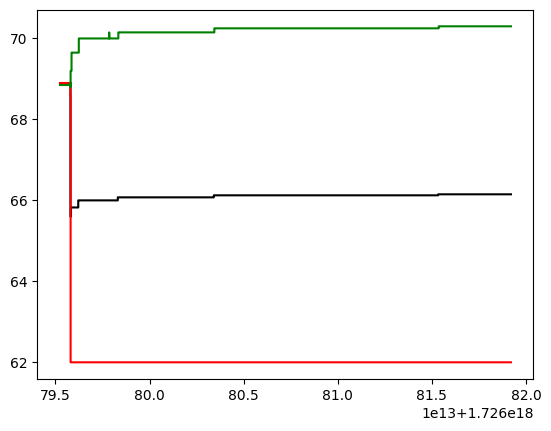

In [0]:
import matplotlib.pyplot as plt
plt.plot(times_2, midspot_30, drawstyle='steps-post', color='black')
plt.plot(times, ask_0, drawstyle='steps-post', color='red')
plt.plot(times, bid_0, drawstyle='steps-post', color='green')

In [0]:
BQ = pd.read_parquet("data/ConflatedBrokerQueue_2024-09-20.parquet")


In [0]:
BQ = BQ[BQ["securityCode_"]==5]
BQ.to_parquet("data/BQ.parquet")

In [0]:
private_trade = pd.read_parquet("data/private_trade_path_2024-09-20.parquet")
private_feed = pd.read_parquet("data/private_feed_path_2024-09-20.parquet")
order_insert = pd.read_parquet("data/order_insert_path_2024-09-20.parquet")
delete_operation = pd.read_parquet("data/delete_operation_path_2024-09-20.parquet")
book = pd.read_parquet("data/OMDCRaw_2024-09-20.parquet")

In [0]:
BQ[BQ["securityCode_"]==5]

,received_,timestampNanos_,eeid_event_id,securityCode_,side_,brokerNumber_,type,broker_queue_msg_index,priority_,level_,createdNanos_
192,1726794000031381708,1726794000031000000,1220475499017404610,5,1,6389,B,0,0,0,1726794000031381708
193,1726794000031381708,1726794000031000000,1220475499017404610,5,2,4107,B,0,0,0,1726794000031381708
194,1726794000031381708,1726794000031000000,1220475499017404610,5,2,6389,B,1,1,0,1726794000031381708
195,1726794000031381708,1726794000031000000,1220475499017404610,5,2,8582,B,5,2,2,1726794000031381708
196,1726794000031381708,1726794000031000000,1220475499017404610,5,2,4107,B,9,3,4,1726794000031381708
...,...,...,...,...,...,...,...,...,...,...,...
82948153,1726819710229411205,1726819710229000000,1220475499036927898,5,2,8944,B,35,32,3,1726819710229411205
82948154,1726819710229411205,1726819710229000000,1220475499036927898,5,2,6722,B,36,33,3,1726819710229411205
82948155,1726819710229411205,1726819710229000000,1220475499036927898,5,2,318,B,37,34,3,1726819710229411205
82948156,1726819710229411205,1726819710229000000,1220475499036927898,5,2,9053,B,38,35,3,1726819710229411205


In [0]:
book = book[book["securityCode_"]=="5"]

In [0]:
book.to_parquet("data/book.parquet")

In [0]:
private_trade.to_parquet("data/private_trade.parquet")
private_feed.to_parquet("data/private_feed.parquet")
order_insert.to_parquet("data/order_insert.parquet")
delete_operation.to_parquet("data/delete_operation.parquet")
book.to_parquet("data/book.parquet")

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:729)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:447)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:447)
	at com.databricks.spark.chauffeur.ChauffeurState.cancelExecutio

In [0]:
BQ.head()

,received_,timestampNanos_,eeid_event_id,securityCode_,side_,brokerNumber_,type,broker_queue_msg_index,priority_,level_,createdNanos_


In [0]:
BQ = pd.read_parquet("data/BQ.parquet")

In [0]:
send_times??

Signature: def send_times(foba_events, sent_times)
Source:   
@provides("send_times")
@enriches("foba_events")
def send_times(foba_events, sent_times):
    calculators = [
        SentTimeCalculator(sent_time, time_name)
        for sent_time in sent_times
        for time_name in sent_time.time_names
    ]

    def sent_times(event):
        kwargs = {
            calculator.sent_field: calculator.calculate(event)
            for calculator in calculators
        }
        return ImmutableRecord(**kwargs)

    return ImmutableDict(
        (event_id, sent_times(event)) for event_id, event in foba_events.items()
    )
File:      /Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/foba_backtest_engine/components/order_book/utils/foba_time.py
Line:      128
Type:      function

In [0]:
processors.append(static_data_info)
        processors.append(static_data_enrichment)

        processors.append(send_times)

        processors.append(fetch_feed_stats_from_book_builders)
        processors.append(annotate_slippages)
        processors.append(full_feed_state_enrichment)
        processors.append(feed_states_at_join)

        processors.append(order_state_creates)
        processors.append(order_matches)
        processors.append(order_deletes)
        processors.append(order_delete_matches)
        
        processors.append(omdc_broker_number_to_name)

        processors.append(get_optiver_trades)
        processors.append(optiver_trade_and_quotes)

        processors.append(category_enrichment)
        processors.append(derived_enrichment)
        # processors.append(enrich_pnl)

        processors.append(event_enricher)

        if enrich_competitor:
            processors.append(omdc_broker_queue)
            processors.append(omdc_order_number_to_broker_number)
            processors.append(competitor_enrichment)
            processors.append(foreign_counterparty_enrichment)
            processors.append(broker_orders_enrichment)

        return processors

In [0]:
mapping = omdc_broker_number_to_name(filter_used)

In [0]:
for key, value in mapping.items():
    print(isinstance(key, int), value)

True Cheong Lee Securities Limited
True Cheong Lee Securities Limited
True Cheong Lee Securities Limited
True Cheong Lee Securities Limited
True Cheong Lee Securities Limited
True Cheong Lee Securities Limited
True CCB International Securities Limited
True CCB International Securities Limited
True CCB International Securities Limited
True CCB International Securities Limited
True CCB International Securities Limited
True KINGKEY SECURITIES GROUP LIMITED
True KINGKEY SECURITIES GROUP LIMITED
True Fu Yip Securities and Investment Company Limited
True Intercontinent Securities Company Limited
True Gransing Securities Co., Limited
True Anglo Chinese Securities, Limited
True Good Harvest Securities Company Limited
True Tarzan Stock & Shares Limited
True Core Pacific - Yamaichi International (H.K.) Limited
True Core Pacific - Yamaichi International (H.K.) Limited
True Core Pacific - Yamaichi International (H.K.) Limited
True Core Pacific - Yamaichi International (H.K.) Limited
True Core Paci

In [0]:
omdc = pd.read_parquet(filter_used.conflated_broker_queue_path)

In [0]:
omdc.head()

IOStream.flush timed out


,received_,timestampNanos_,eeid_event_id,securityCode_,side_,brokerNumber_,type,broker_queue_msg_index,priority_,level_,createdNanos_
0,1726794000003949138,1726794000003000000,1220475499017404417,1359,2,2877,B,0,0,0,1726794000003949138
1,1726794000003949138,1726794000003000000,1220475499017404417,1359,1,2873,B,0,1,0,1726794000003949138
2,1726794000003949138,1726794000003000000,1220475499017404417,1359,1,2873,B,1,2,1,1726794000003949138
3,1726794000003949138,1726794000003000000,1220475499017404417,1359,2,2877,B,2,3,1,1726794000003949138
4,1726794000003949138,1726794000003000000,1220475499017404417,1359,1,2873,B,2,4,1,1726794000003949138


IOStream.flush timed out


In [0]:
def get_omdc_broker_queue(filter, security_codes):
    start_time, end_time, date_to_pull, date_filter = (
        to_milli_timestamp(filter.start_time) * 1e6,
        to_milli_timestamp(filter.end_time) * 1e6,
        filter.start_time.format("YYYY-MM-DD"),
        int(filter.start_time.format("YYYYMMDD")),
    )
    # omdc = pd.read_feather(
    #     "/Users/kartikeyabisht/FobaBacktestEngine/temp_data/OMDC.feather"
    # )
    omdc = pd.read_parquet(filter.conflated_broker_queue_path)
    

    omdc["securityCode_"] = omdc["securityCode_"].apply(
        lambda x: str(x) if isinstance(x, int) else x
    )
    omdc = omdc[omdc["securityCode_"].isin(security_codes)]
    omdc_filter_time = omdc[
        (omdc["createdNanos_"] >= start_time)
        & (omdc["createdNanos_"] <= end_time)
    ]
    omdc_final = omdc_filter_time.sort_values(
        by=["timestampNanos_", "side_", "priority_"]
    )
    omdc_final_list = []
    for _, row in omdc_final.iterrows():
        row_dict = row.to_dict()
        omdc_final_list.append(MyRow(row_dict))
    return omdc_final_list

In [0]:
omdc_broker_queue??

Signature: def omdc_broker_queue(filter, foba_events)
Source:   
@provides("omdc_broker_queue")
def omdc_broker_queue(filter, foba_events):
    security_codes = ImmutableDict(
        (event.book_id, event.book_id) for event in foba_events.values()
    )
    result_dict = dict()

    books = []
    codes = []
    for book, code in security_codes.items():
        books.append(book)
        codes.append(code)

    start = 0
    step = 50
    while start < len(books):
        end = min(len(books), start + step)
        data = get_omdc_broker_queue(filter, codes[start:end])
        for book, code in zip(books[start:end], codes[start:end]):
            result_dict[book] = [e for e in data if e.securityCode_ == code]
        start = end

    return ImmutableDict(
        (book, broker_queue) for book, broker_queue in result_dict.items()
    )
File:      /Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/foba_backtest_engine/components/order_book/utils/foba_omdc_broker_queue_processo

In [0]:

        processors.append(static_data_info)
        processors.append(static_data_enrichment)

        processors.append(send_times)

        processors.append(fetch_feed_stats_from_book_builders)
        processors.append(annotate_slippages)
        processors.append(full_feed_state_enrichment)
        processors.append(feed_states_at_join)

        processors.append(order_state_creates)
        processors.append(order_matches)
        processors.append(order_deletes)
        processors.append(order_delete_matches)
        
        processors.append(omdc_broker_number_to_name)

        processors.append(get_optiver_trades)
        processors.append(optiver_trade_and_quotes)

        processors.append(category_enrichment)
        processors.append(derived_enrichment)
        # processors.append(enrich_pnl)

        processors.append(event_enricher)

        if enrich_competitor:
            processors.append(omdc_broker_queue)
            processors.append(omdc_order_number_to_broker_number)
            processors.append(competitor_enrichment)
            processors.append(foreign_counterparty_enrichment)
            processors.append(broker_orders_enrichment)

In [0]:
from collections import namedtuple

import pandas as pd

from foba_backtest_engine.components.order_book.utils import MyRow as MyRow
from foba_backtest_engine.enrichment import provides
from foba_backtest_engine.utils.base_utils import ImmutableDict
from foba_backtest_engine.utils.time_utils import to_milli_timestamp

"""
Expected BrokerQueue (for OMDC only)
    - Broker queue arrives in a conflated manner & is sided ... separate for ask and bid
    
    e.g. Ask Broker Queue example

    || PRICE  || ORDERS
       100.20  |  [1000, 2000, 1300, 5550, 1000]      (volume)
               |  [9481, 9910, 4123, 5441, 2221]      (brokerId)

       100.00  |  [4000, 5500]                        (volume)
               |  [9481, 2221]                        (brokerId)

    
               Entry:    1    2    3    4   5   6   7   8   
        BQ ->  Items:  9481 9910 4123 5441 2221 1 9498 2221
                Type:    B    B    B    B   B   S   B   B
    
    - On the FPGA .. as the BQ arrives in a byte array stream the BEST way to store the queue is item-wise
    - each row should have:
        - securityCode  (from 4 byte Uint32 in message)
        - priority_ this is a number from [0, 40] ... i.e. priority from front of BEST LEVEL (this just increments on every "B" item)
        - brokerNumber_ (extracted from the item)
        - level_    this defaults to 0 unless we receive "S" items .. then we increment by (1)

"""

OmdcBrokerQueue = namedtuple(
    "OmdcBrokerQueue",
    (
        "createdNanos_",
        "received_",
        "seq_",
        "securityCode_",
        "side_",
        "priority_",
        "brokerNumber_",
        "level_",
    ),
)


def get_omdc_broker_queue(filter, security_codes):
    start_time, end_time, date_to_pull, date_filter = (
        to_milli_timestamp(filter.start_time) * 1e6,
        to_milli_timestamp(filter.end_time) * 1e6,
        filter.start_time.format("YYYY-MM-DD"),
        int(filter.start_time.format("YYYYMMDD")),
    )
    # omdc = pd.read_feather(
    #     "/Users/kartikeyabisht/FobaBacktestEngine/temp_data/OMDC.feather"
    # )
    omdc = pd.read_parquet(filter.conflated_broker_queue_path)
    

    omdc["securityCode_"] = omdc["securityCode_"].apply(
        lambda x: str(x) if isinstance(x, int) else x
    )
    omdc = omdc[omdc["securityCode_"].isin(security_codes)]
    omdc_filter_time = omdc[
        (omdc["createdNanos_"] >= start_time)
        & (omdc["createdNanos_"] <= end_time)
    ]
    omdc_final = omdc_filter_time.sort_values(
        by=["timestampNanos_", "side_", "priority_"]
    )
    omdc_final_list = []
    for _, row in omdc_final.iterrows():
        row_dict = row.to_dict()
        omdc_final_list.append(MyRow(row_dict))
    return omdc_final_list


@provides("omdc_broker_queue")
def omdc_broker_queue(filter, foba_events):
    security_codes = ImmutableDict(
        (event.book_id, event.book_id) for event in foba_events.values()
    )
    result_dict = dict()

    books = []
    codes = []
    for book, code in security_codes.items():
        books.append(book)
        codes.append(code)

    start = 0
    step = 50
    while start < len(books):
        end = min(len(books), start + step)
        data = get_omdc_broker_queue(filter, codes[start:end])
        for book, code in zip(books[start:end], codes[start:end]):
            result_dict[book] = [e for e in data if e.securityCode_ == code]
        start = end

    return ImmutableDict(
        (book, broker_queue) for book, broker_queue in result_dict.items()
    )


In [0]:
from collections import namedtuple

import pandas as pd

from foba_backtest_engine.components.order_book.utils import MyRow as MyRow
from foba_backtest_engine.enrichment import provides
from foba_backtest_engine.utils.base_utils import ImmutableDict
from foba_backtest_engine.utils.time_utils import to_milli_timestamp

"""
Expected BrokerQueue (for OMDC only)
    - Broker queue arrives in a conflated manner & is sided ... separate for ask and bid
    
    e.g. Ask Broker Queue example

    || PRICE  || ORDERS
       100.20  |  [1000, 2000, 1300, 5550, 1000]      (volume)
               |  [9481, 9910, 4123, 5441, 2221]      (brokerId)

       100.00  |  [4000, 5500]                        (volume)
               |  [9481, 2221]                        (brokerId)

    
               Entry:    1    2    3    4   5   6   7   8   
        BQ ->  Items:  9481 9910 4123 5441 2221 1 9498 2221
                Type:    B    B    B    B   B   S   B   B
    
    - On the FPGA .. as the BQ arrives in a byte array stream the BEST way to store the queue is item-wise
    - each row should have:
        - securityCode  (from 4 byte Uint32 in message)
        - priority_ this is a number from [0, 40] ... i.e. priority from front of BEST LEVEL (this just increments on every "B" item)
        - brokerNumber_ (extracted from the item)
        - level_    this defaults to 0 unless we receive "S" items .. then we increment by (1)

"""

OmdcBrokerQueue = namedtuple(
    "OmdcBrokerQueue",
    (
        "createdNanos_",
        "received_",
        "seq_",
        "securityCode_",
        "side_",
        "priority_",
        "brokerNumber_",
        "level_",
    ),
)


def get_omdc_broker_queue(filter, security_codes):
    start_time, end_time, date_to_pull, date_filter = (
        to_milli_timestamp(filter.start_time) * 1e6,
        to_milli_timestamp(filter.end_time) * 1e6,
        filter.start_time.format("YYYY-MM-DD"),
        int(filter.start_time.format("YYYYMMDD")),
    )
    # omdc = pd.read_feather(
    #     "/Users/kartikeyabisht/FobaBacktestEngine/temp_data/OMDC.feather"
    # )
    omdc = pd.read_parquet(filter.conflated_broker_queue_path)
    

    omdc["securityCode_"] = omdc["securityCode_"].apply(
        lambda x: str(x) if isinstance(x, int) else x
    )
    omdc = omdc[omdc["securityCode_"].isin(security_codes)]
    omdc_filter_time = omdc[
        (omdc["createdNanos_"] >= start_time)
        & (omdc["createdNanos_"] <= end_time)
    ]
    omdc_final = omdc_filter_time.sort_values(
        by=["timestampNanos_", "side_", "priority_"]
    )
    omdc_final_list = []
    for _, row in omdc_final.iterrows():
        row_dict = row.to_dict()
        omdc_final_list.append(MyRow(row_dict))
    return omdc_final_list


@provides("omdc_broker_queue")
def omdc_broker_queue(filter, foba_events):
    security_codes = ImmutableDict(
        (event.book_id, event.book_id) for event in foba_events.values()
    )
    result_dict = dict()

    books = []
    codes = []
    for book, code in security_codes.items():
        books.append(book)
        codes.append(code)

    start = 0
    step = 50
    while start < len(books):
        end = min(len(books), start + step)
        data = get_omdc_broker_queue(filter, codes[start:end])
        for book, code in zip(books[start:end], codes[start:end]):
            result_dict[book] = [e for e in data if e.securityCode_ == code]
        start = end

    return ImmutableDict(
        (book, broker_queue) for book, broker_queue in result_dict.items()
    )


In [0]:
feedcodes

['1',
 '101',
 '1024',
 '1038',
 '1044',
 '1088',
 '1093',
 '1099',
 '11',
 '1109',
 '1113',
 '1171',
 '1177',
 '1186',
 '12',
 '1209',
 '1211',
 '1288',
 '1299',
 '1336',
 '1339',
 '1347',
 '135',
 '1359',
 '1378',
 '1398',
 '151',
 '1519',
 '16',
 '1658',
 '17',
 '175',
 '1797',
 '1800',
 '1801',
 '1810',
 '1816',
 '1833',
 '1876',
 '1898',
 '19',
 '1918',
 '1928',
 '1929',
 '1988',
 '1997',
 '2',
 '20',
 '2007',
 '2013',
 '2015',
 '2018',
 '2020',
 '2202',
 '2238',
 '2269',
 '23',
 '2313',
 '2318',
 '2319',
 '2328',
 '2331',
 '2333',
 '2359',
 '2382',
 '2388',
 '241',
 '2518',
 '2600',
 '2601',
 '2618',
 '2628',
 '267',
 '268',
 '2688',
 '27',
 '285',
 '288',
 '2899',
 '291',
 '3',
 '316',
 '322',
 '3323',
 '3328',
 '3333',
 '358',
 '3690',
 '3692',
 '384',
 '386',
 '388',
 '3888',
 '390',
 '3968',
 '3988',
 '489',
 '5',
 '522',
 '6',
 '6030',
 '6060',
 '6098',
 '6186',
 '66',
 '6618',
 '6666',
 '669',
 '6690',
 '6837',
 '6862',
 '688',
 '700',
 '728',
 '753',
 '762',
 '772',
 '777'

In [0]:
selected_columns = ['t0', 'omd_send_ts', 'eeid_event_id', 'security_code', 'side', 'item', 'type', 'broker_queue_msg_index']

OMDC = (spark.read.parquet(f"/Volumes/external/opapac-ess-prd-apse2/hacksaw/sehk/omdc_broker_queue/market_session_date={date_to_run.isoformat()}/")
        .filter(F.col("security_code").isin(feedcodes))
        .select(*selected_columns)
        .toPandas())

In [0]:
def get_and_persist_omdc(feedcodes, date_to_run, path="/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/data/ConflatedBrokerQueue_{date_to_run}.parquet"):
    selected_columns = ['t0', 'omd_send_ts', 'eeid_event_id', 'security_code', 'side', 'item', 'type', 'broker_queue_msg_index']

    OMDC = (spark.read.parquet(f"/Volumes/external/opapac-ess-prd-apse2/hacksaw/sehk/omdc_broker_queue/market_session_date={date_to_run.isoformat()}/")
            .filter(F.col("security_code").isin(feedcodes))
            .select(*selected_columns)
            .toPandas())

    OMDC = OMDC.rename(columns = {
        "t0": "received_",
        "omd_send_ts": "timestampNanos_",
        "security_code":"securityCode_",
        "side": "side_",
    })

    OMDC["priority_pre_step"] = np.where(OMDC["type"] == "B", 1, 0)
    OMDC = OMDC.sort_values(by=['eeid_event_id','securityCode_','side_','broker_queue_msg_index']).reset_index(drop=True)
    OMDC["priority_"] = OMDC.groupby(['eeid_event_id','securityCode_','side_'])["priority_pre_step"].cumsum()-1
    OMDC["level_pre_step"] = np.where(OMDC["item"] == 0, 0,np.where(OMDC["type"] == "S", 1, 0))
    OMDC["level_"] = OMDC.groupby(['eeid_event_id','securityCode_','side_'])["level_pre_step"].cumsum()

    OMDC = OMDC.drop(columns=['priority_pre_step', 'level_pre_step'])
    OMDC = OMDC.rename(columns = {"item":"brokerNumber_"})

    OMDC["createdNanos_"] = OMDC["received_"]
    OMDC = OMDC[OMDC["type"]=="B"].sort_values(['eeid_event_id','securityCode_','side_','broker_queue_msg_index']).reset_index(drop = True)

    path_final = path.format(date_to_run=date_to_run)
    OMDC.to_parquet(path_final)
    return path_final

In [0]:
OMDC["priority_pre_step"] = np.where(OMDC["type"] == "B", 1, 0)
OMDC = OMDC.sort_values(by=['eeid_event_id','securityCode_','side_','broker_queue_msg_index']).reset_index(drop=True)
OMDC["priority_"] = OMDC.groupby(['eeid_event_id','securityCode_','side_'])["priority_pre_step"].cumsum()-1
OMDC["level_pre_step"] = np.where(OMDC["item"] == 0, 0,np.where(OMDC["type"] == "S", 1, 0))
OMDC["level_"] = OMDC.groupby(['eeid_event_id','securityCode_','side_'])["level_pre_step"].cumsum()

In [0]:
OMDC["level_pre_step"] = np.where(OMDC["item"] == 0, 0,np.where(OMDC["type"] == "S", 1, 0))
OMDC["level_"] = OMDC.groupby(['eeid_event_id','securityCode_','side_'])["level_pre_step"].cumsum()

In [0]:
OMDC = OMDC.drop(columns=['is_B', 'increment_level'])
OMDC = OMDC.rename(columns = {"item":"brokerNumber_"})
OMDC["createdNanos_"] = OMDC["received_"]
OMDC = OMDC[OMDC["type"]=="B"].sort_values(["eeid_event_id", "broker_queue_msg_index"]).reset_index(drop = True)

,received_,timestampNanos_,eeid_event_id,securityCode_,side_,item,type,broker_queue_msg_index,priority_pre_step,priority_
0,1726794000003949138,1726794000003000000,1220475499017404417,1359,1,2873,B,0,1,0
1,1726794000003949138,1726794000003000000,1220475499017404417,1359,1,2873,B,1,1,1
2,1726794000003949138,1726794000003000000,1220475499017404417,1359,1,2873,B,2,1,2
3,1726794000003949138,1726794000003000000,1220475499017404417,1359,1,1,S,3,0,2
4,1726794000003949138,1726794000003000000,1220475499017404417,1359,1,2873,B,4,1,3


In [0]:
OMDC.head(30)

,received_,timestampNanos_,eeid_event_id,securityCode_,side_,item,type,broker_queue_msg_index,priority_pre_step,priority_,level_pre_step,level_
0,1726794000003949138,1726794000003000000,1220475499017404417,1359,1,2873,B,0,1,0,0,0
1,1726794000003949138,1726794000003000000,1220475499017404417,1359,1,2873,B,1,1,1,0,0
2,1726794000003949138,1726794000003000000,1220475499017404417,1359,1,2873,B,2,1,2,0,0
3,1726794000003949138,1726794000003000000,1220475499017404417,1359,1,1,S,3,0,2,1,1
4,1726794000003949138,1726794000003000000,1220475499017404417,1359,1,2873,B,4,1,3,0,1
5,1726794000003949138,1726794000003000000,1220475499017404417,1359,1,2873,B,5,1,4,0,1
6,1726794000003949138,1726794000003000000,1220475499017404417,1359,1,2,S,6,0,4,1,2
7,1726794000003949138,1726794000003000000,1220475499017404417,1359,1,2873,B,7,1,5,0,2
8,1726794000003949138,1726794000003000000,1220475499017404417,1359,1,2873,B,8,1,6,0,2
9,1726794000003949138,1726794000003000000,1220475499017404417,1359,2,2877,B,0,1,0,0,0


In [0]:
def process_packet(packet):
    packet = packet.sort_values(by='broker_queue_msg_index').reset_index(drop=True)
    is_S = packet['type'] == 'S'
    is_B = ~is_S  
    packet['priority'] = -1
    packet.loc[is_B, 'priority'] = is_B.cumsum()[is_B] - 1
    increment_level = is_S & packet['item'].isin([1, 2])
    packet['level_'] = increment_level.cumsum()

    return packet
    
def get_and_persist_omdc(feedcodes, date_to_run, path="/Workspace/Users/kartikeya.bisht@optiver.com.au/FOBA_create/data/ConflatedBrokerQueue_{date_to_run}.parquet"):
    selected_columns = ['t0', 'omd_send_ts', 'eeid_event_id', 'security_code', 'side', 'item', 'type', 'broker_queue_msg_index']

    OMDC = (spark.read.parquet(f"/Volumes/external/opapac-ess-prd-apse2/hacksaw/sehk/omdc_broker_queue/market_session_date={date_to_run.isoformat()}/")
            .filter(F.col("security_code").isin(feedcodes))
            .select(*selected_columns)
            .toPandas())

    OMDC = OMDC.rename(columns = {
        "t0": "received_",
        "omd_send_ts": "timestampNanos_",
        "security_code":"securityCode_",
        "side": "side_",
    })

    OMDC = OMDC.sort_values(by=['eeid_event_id', 'securityCode_', 'broker_queue_msg_index']).reset_index(drop=True)
    OMDC2 = OMDC.copy()
    group_keys = ['eeid_event_id', 'securityCode_']

    OMDC['is_B'] = (OMDC['type'] == 'B').astype(int)
    OMDC['priority_'] = OMDC.groupby(group_keys)['is_B'].cumsum() - 1

    OMDC['increment_level'] = ((OMDC['type'] == 'S') & (OMDC['item'] != 0)).astype(int)
    OMDC['level_'] = OMDC.groupby(group_keys)['increment_level'].cumsum()
    OMDC = OMDC.drop(columns=['is_B', 'increment_level'])
    OMDC = OMDC.rename(columns = {"item":"brokerNumber_"})
    OMDC["createdNanos_"] = OMDC["received_"]
    OMDC = OMDC[OMDC["type"]=="B"].sort_values(["eeid_event_id", "broker_queue_msg_index"]).reset_index(drop = True)

    path_final = path.format(date_to_run=date_to_run)
    OMDC.to_parquet(path_final)
    return path_final